# How to Develop ARIMA Models for Multi-step Energy Usage Forecasting

In [8]:
# acf and pacf plots of total power usage
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [9]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [10]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

In [11]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('../Data/household_power_consumption/household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('../Data/household_power_consumption/household_power_consumption_days.csv')

C:\Users\pc\AppData\Local\Temp\ipykernel_16128\2714633189.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption.csv', header=0, infer_datetime_format=True,


(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

1442


C:\Users\pc\AppData\Local\Temp\ipykernel_16128\2317917279.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,


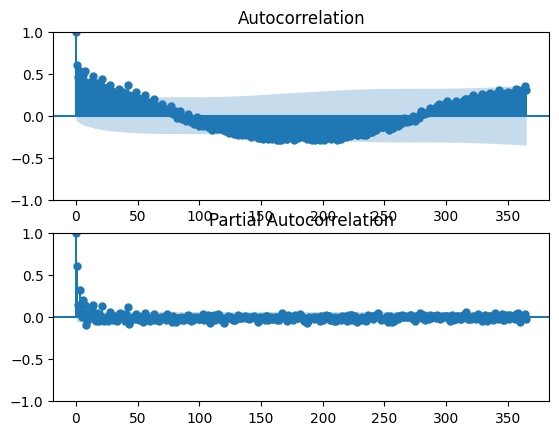

In [12]:
import logging

# load the new file
dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

print(len(dataset))
logging.debug(len(dataset))
# split into train and test
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)
# plots
pyplot.figure()
lags = 365
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

In [23]:
# arima forecast for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

In [14]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [15]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [16]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [17]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [18]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

In [25]:
# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    # model_fit = model.fit(disp=False)
    model_fit = model.fit()
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

C:\Users\pc\AppData\Local\Temp\ipykernel_16128\1137361007.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,


arima: [465.476] 427.9, 448.5, 395.0, 521.9, 449.4, 379.6, 598.3


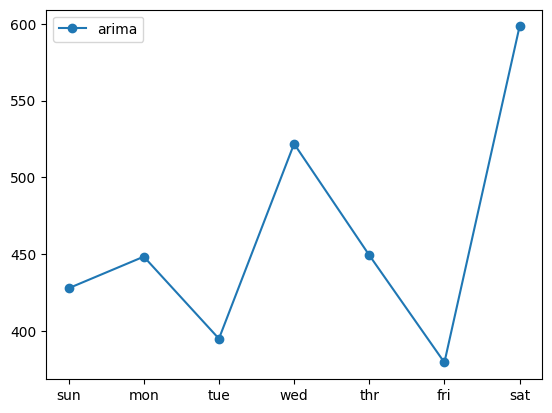

In [26]:
# load the new file
dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()